# Retroperitoneal sarcoma radiomics study
# Prediction of tumour type and grade
# Logistic regression with group selection

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500, 'display.max_rows', 500, 'display.precision', 3)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_validate
import os, warnings, copy, sys, shutil
import matplotlib.pyplot as plt
import pickle
from time import strftime, localtime
from pyirr import intraclass_correlation
from scipy.stats import skew
import seaborn as sns
from scipy.stats import mannwhitneyu

rootFolder = os.path.join(os.path.expanduser("~"), 'Dicom Files/RADSARC_R')

# this module should be in the same folder as this notebook
from fit_LR_groupSelection_correlationThresholds import fit_LR_groupSelection_correlationThresholds, plotResultExperiments, displayOneExperiment

n_splits = 10
n_repeats = 50
thresholds = np.round(np.arange(0.6,1.00001,0.02), 2)
penalty = 'l1'

displayAll = True

## Create output and copy code

In [2]:
%%capture out_stream

# set output folder to None if this is a fresh run
# set output folder to an existing location to load pre-saved results from there
outputFolder = None #'/Users/morton/Dicom Files/RADSARC_R/XNAT/experiments/LR_GroupSelection__20220924_0958'

if outputFolder is None:
    
    saveOutputs = True
    
    outputFolder = os.path.join(rootFolder, 'XNAT/experiments/LR_GroupSelection__' + strftime("%Y%m%d_%H%M", localtime()))
    os.mkdir(outputFolder)
    os.mkdir(os.path.join(outputFolder, 'code'))
    os.mkdir(os.path.join(outputFolder, 'figures'))
    
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome.ipynb'))

    file1 = os.path.join(os.path.abspath(""), 'fit_LR_groupSelection_correlationThresholds.py')
    shutil.copyfile(file1, os.path.join(outputFolder, 'code', 'fit_LR_groupSelection_correlationThresholds.py'))

    user = os.path.expanduser("~")
    file2 = os.path.join(user, 'Documents/git/git_icrpythonradiomics/machineLearning/featureSelection.py')
    shutil.copyfile(file2, os.path.join(outputFolder, 'code', 'featureSelection.py'))

else:
    
    saveOutputs = False

### Utility functions

In [3]:
def groupStrsDisp(strGroups):
    
    def tidyGroup(strGroup):
        if strGroup == '':
            strGroup = 'all'
        strGroup = strGroup.replace('glcm|gldm|glszm|glrlm|ngtdm','texture')
        strGroup = strGroup.replace('firstorder|histogram','firstorder')
        return strGroup

    if isinstance(strGroups, str):
        return tidyGroup(strGroups)
    
    if isinstance(strGroups, list):
        return [tidyGroup(x) for x in strGroups]

## Load data

In [4]:
# TRAINING DATA

# open clinical spreadsheet
clinicalSpreadsheet = os.path.join(rootFolder, 'ClinicalData', 'Clinical data for analysis.xlsx')
dfClinical = pd.read_excel(clinicalSpreadsheet, sheet_name='220818_Completed segs', header = 2, skiprows=[3], nrows=170, engine='openpyxl')
dfClinical.sort_values('Anon Code', inplace=True, ignore_index=True)

# simplify grade
dfClinical['Grade_1_234'] = dfClinical['Grade']==1
dfClinical['Grade_12_34'] = dfClinical['Grade']<=2

# binarised outcome data
cutoffYears = 1.5
cutoffDays = cutoffYears*365

# Recurrence data are for local (arfs) and distant (dmfs) metastases
# Combine these into an overall recurrence status, i.e. if either arfs==1 or dmfs==1 then rfs==1, and then the 
# recurrence time is the shorter of the two
dfClinical.drop(['rfs', 't_rfs'], inplace=True, axis=1)
dfClinical['rfs'] = np.logical_or(dfClinical['arfs']==1, dfClinical['dmfs']==1).astype(int)
dfClinical['t_rfs'] = dfClinical[['t_arfs', 't_dmfs']].min(axis=1)

def binarizeOutcome(df, new_val1, new_val2, old_val2, feat_time, feat_event, new_feat_name):

    df[new_feat_name] = new_val1
    df.loc[df[feat_time] >= cutoffDays, new_feat_name] = new_val2
    df.loc[np.logical_and(df[feat_time] < cutoffDays, df[feat_event] == old_val2), new_feat_name] = 'Unknown'

binarizeOutcome(dfClinical, 'Event', 'No event', 'Alive', 't_os', 'os', 'overall_survival')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_arfs', 'arfs', 'local_recurrence')
binarizeOutcome(dfClinical, 'Event', 'No event', 0, 't_rfs', 'rfs', 'any_recurrence')

###############
# NEED TO ADD CLINICAL FEATURES TO MODELS!!!!!
###############


# Radiation_neoadj needed to exclude patients that had radiotherapy (3 patients)
cols = ['Anon Code', 
        'Grade_1_234', 
        'Grade_12_34', 
        'subtype', 
        'overall_survival', 
        'distant_recurrence',
        'local_recurrence',
        'any_recurrence',
        'Radiation_neoadj']

dfClinical = dfClinical[cols]

# TEST DATA

# open clinical spreadsheet
clinicalSpreadsheetTest = os.path.join(rootFolder, 'ClinicalData', 'EORTC_Radsarc_Clindata.xlsx')
dfClinicalTest = pd.read_excel(clinicalSpreadsheetTest, sheet_name='Completed segs_for analysis', engine='openpyxl')
dfClinicalTest['Anon Code'] = ['EORTCRSRC_' + str(int(x)).zfill(3) for x in dfClinicalTest['PATID']]

# simplify grade
dfClinicalTest['Grade_1_234'] = dfClinicalTest['grade']==1
dfClinicalTest['Grade_12_34'] = dfClinicalTest['grade']<=2

# make rfs data

dfClinicalTest['rfs'] = np.logical_or(dfClinicalTest['arfs2']==1, dfClinicalTest['dmfs']==1).astype(int)
dfClinicalTest['t_rfs'] = dfClinicalTest[['t_arfs2', 't_dmfs']].min(axis=1)

# binarised outcome data
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_ss', 'ss', 'overall_survival')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_dmfs', 'dmfs', 'distant_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_arfs2', 'arfs2', 'local_recurrence')
binarizeOutcome(dfClinicalTest, 'Event', 'No event', 1, 't_rfs', 'rfs', 'any_recurrence')

# add this column to match training data
dfClinicalTest['Radiation_neoadj'] = 0

dfClinicalTest = dfClinicalTest[cols]


In [5]:
def readRadData(folder):
    df = pd.read_csv(os.path.join(rootFolder, 'XNAT', 'extractions', folder, 'radiomicFeatures', 'radiomicFeatures.csv'))
    df.drop(list(df.filter(regex = 'source')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'diagnostic')), axis = 1, inplace = True)
    df.drop(list(df.filter(regex = 'histogram')), axis = 1, inplace = True)
    return df

# training
dfRad = readRadData('extractions__20221122_1628_allRegions_volFracApprox')

# reproducibility
dfRadRep = readRadData('extractions__20221122_2037_repro_volFracApprox')

# open test data
dfRadTest = readRadData('extractions__20221125_0939_eortcTestData')

## Compute ICCs and remove unreproducible features

In [6]:
dfRadOri = dfRad.copy()

subjectIDs = dfRadOri.merge(dfRadRep, on='StudyPatientName').StudyPatientName

# select rows and make sure they are both sorted on SubjectID
dfRadOri = dfRadOri.loc[dfRadOri['StudyPatientName'].isin(subjectIDs)]
dfRadOri.sort_values('StudyPatientName', axis=0, inplace=True)

dfRadRep = dfRadRep.loc[dfRadRep['StudyPatientName'].isin(subjectIDs)]
dfRadRep.sort_values('StudyPatientName', axis=0, inplace=True)

# remove high/mid/low_enhancing features
dfRadOri.drop(list(dfRadOri.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'low_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'mid_enhancing_original')), axis = 1, inplace = True)
dfRadOri.drop(list(dfRadOri.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'high_enhancing_original')), axis = 1, inplace = True)

# remove these features
dfRadOri.drop(list(dfRadOri.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)
dfRadRep.drop(list(dfRadRep.filter(regex = 'calcificationDeleted')), axis = 1, inplace = True)

dfRadOri.reset_index(inplace=True)
dfRadRep.reset_index(inplace=True)

iccValues = []
featNames = []
for col in dfRadOri.columns:
    if col == 'StudyPatientName' or col=='index':
        continue
    data = np.stack((dfRadOri[col], dfRadRep[col]), axis=1)
    featNames.append(col)
    iccValues.append(intraclass_correlation(data, "twoway", "agreement").value)
iccDf = pd.DataFrame({'Feature':featNames, 'ICC':iccValues})

iccThreshold = 0.75

reproducibleFeatures = list(iccDf.Feature[iccDf.ICC>iccThreshold])
reproducibleFeatures.append('StudyPatientName')

dfRad = dfRad.filter(reproducibleFeatures)
dfRadTest = dfRadTest.filter(reproducibleFeatures)

## Log transform positive skewed parameters

In [7]:
def makeLog(df, feat, offset=0):
    df[feat+'_log'] = np.log(df[feat]+offset)
    df.drop(feat, axis=1, inplace=True)
    return df

for feat in dfRad.filter(regex='lesion_original', axis=1).columns:
    if skew(dfRad[feat])>3 and np.all(dfRad[feat]>0):
        dfRad = makeLog(dfRad, feat)
        dfRadTest = makeLog(dfRadTest, feat)

# this is heavily skewed, but has minimum value -87
dfRad = makeLog(dfRad, 'lesion_original_glcm_ClusterShade', offset=90)
dfRadTest = makeLog(dfRadTest, 'lesion_original_glcm_ClusterShade', offset=90)

In [8]:
def featureClassDensities(df_Train, df_Test, featureClass, spSize):
    f,a = plt.subplots(spSize[0], spSize[1], figsize=(20,12))
    a = a.ravel()
    for n, feat in enumerate(df_Train.filter(regex = featureClass, axis = 1).columns):
        df1 = pd.DataFrame(df_Train[feat].copy())
        df1['Data'] = 'train'
        df2 = pd.DataFrame(df_Test[feat].copy())
        df2['Data'] = 'test'
        dfPlot = pd.concat([df1, df2])
        dfPlot.reset_index(drop=True, inplace=True)
        featPlot = feat.replace('lesion_original_' + featureClass + '_','')
        dfPlot.rename(columns={feat:featPlot}, inplace=True)
        sns.kdeplot(data=dfPlot, x=featPlot, hue='Data', ax = a[n], common_grid=True, common_norm=False)

if False:
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'shape', (3, 5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'firstorder', (3,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glcm', (4,6))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glrlm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'glszm', (4,4))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'gldm', (3,5))
    featureClassDensities(dfRad.filter(regex='lesion_original'), dfRadTest.filter(regex='lesion_original'), 'ngtdm', (2,3))


## Useful functions

In [9]:
def prepData(dfC, dfR, target, featureSet, removeTargetUnknown=True, replaceTargetUnknown=None, removeRxPatients=False):
    
    df = dfC.merge(dfR, left_on='Anon Code', right_on='StudyPatientName')
    df.drop('Anon Code', axis=1, inplace=True)
    df.drop('StudyPatientName', axis=1, inplace=True)
    
    # remove any patients that had radiotherapy
    if removeRxPatients:
        df = df.loc[df['Radiation_neoadj']!=1,:]
    
    df = df.filter(regex=featureSet + '|' + target)

    # replace any instances where target = 'Unknown' by replaceTargetUnknown
    if replaceTargetUnknown is not None:
        df.loc[df[target] == 'Unknown',target] = replaceTargetUnknown
        
    if removeTargetUnknown:
        df = df.loc[df[target] != 'Unknown',:]
        
        
    
    return df

def fitModelOrLoadSaved(df, target, settings, qlf):
    
    if os.path.exists(qlf):
        with open(qlf, 'rb') as handle:
            result = pickle.load(handle)
    else:
        result = fit_LR_groupSelection_correlationThresholds(df, target, settings)

        if saveOutputs:
            with open(qlf, 'wb') as handle:
                pickle.dump(result, handle)

    return copy.deepcopy(result)

def getTrainTestResults(result):
    
    # find best model i.e. across all thresholds
    AUROC_cv = np.array([np.mean(x['cv_result']['test_score']) for x in result['experiments']])
    idx = np.argmax(AUROC_cv)
    bestExperiment = result['experiments'][idx]

    trainScore = bestExperiment['model'].predict_proba(df.drop(target, axis=1))
    testScore = bestExperiment['model'].predict_proba(dfTest.drop(target, axis=1))
    
    aucTest = roc_auc_score(dfTest[target], testScore[:,1])
    classLabels = list(set(dfTest[target]))
 
    if aucTest>0.6:
        # get p-value on test data
        testScores0 = testScore[dfTest[target]==classLabels[0],1]
        testScores1 = testScore[dfTest[target]==classLabels[1],1]
        _, pValue = mannwhitneyu(testScores0, testScores1, alternative='two-sided')
        pValueStr = str(pValue)
    else:
        pValue = ''
        pValueStr = 'not computed'
        
    nC0 = np.sum(df[target]==classLabels[0])
    nC1 = np.sum(df[target]==classLabels[1])
    nC0t = np.sum(dfTest[target]==classLabels[0])
    nC1t = np.sum(dfTest[target]==classLabels[1])
    aucTrainResub = roc_auc_score(df[target], trainScore[:,1])
    aucTrainCV = np.mean(bestExperiment['cv_result']['test_score'])
    
    
    print('train #      = ' + str(nC0 + nC1) + ' = ' + str(nC0) + ' : ' + str(nC1) + ' (' + str(np.round(100*nC0/(nC0+nC1),1)) + '%)')
    print('train resub  = ' + str(np.round(aucTrainResub,3)))
    print('train CV     = ' + str(np.round(aucTrainCV,3)))
    print('test #       = ' + str(nC0t + nC1t) + ' = ' + str(nC0t) + ' : ' + str(nC1t) + ' (' + str(np.round(100*nC0t/(nC0t+nC1t),1)) + '%)')
    print('test         = ' + str(np.round(aucTest,3)))
    print('test p-value = ' + pValueStr)
    print('\n')

    return {'nTrainA':nC0,
            'nTrainB':nC1,
            'nTestA':nC0t,
            'nTestB':nC1t,
            'AUC train resub':aucTrainResub,
            'AUC train CV':aucTrainCV,
            'AUC test':aucTest,
            'p-value test':pValue}


## Settings for different feature sets

In [10]:
textureStr = 'glcm|gldm|glszm|glrlm|ngtdm'

# variables are defined at the top of this notebook
defaultSettings = {'n_splits':n_splits, 
                   'n_repeats':n_repeats,
                   'thresholds':thresholds,
                   'penalty':penalty
                   }

settingsDict = {}

# standard features
fs = 'lesion_original'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features'
settingsDict[fs]['ID'] = 'standard'
settingsDict[fs]['groupHierarchy'] = ['shape',
                                      'firstorder',
                                      textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['shape', 'firstorder']


# volume fraction + standard features
fs = 'lesion_original|VolumeFraction'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + volume fraction'
settingsDict[fs]['ID'] = 'volFrac'
settingsDict[fs]['groupHierarchy'] = ['VolumeFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'VolumeFraction|shape',
                                      'VolumeFraction|firstorder',
                                      'VolumeFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['VolumeFraction', 'shape', 'firstorder']


# approximate volume fraction + standard features
fs = 'lesion_original|ApproxVolFraction'
settingsDict[fs] = defaultSettings.copy()
settingsDict[fs]['name'] = 'Standard radiomics features + approximate volume fraction'
settingsDict[fs]['ID'] = 'approxVolFrac'
settingsDict[fs]['groupHierarchy'] = ['ApproxVolFraction',
                                      'shape',
                                      'firstorder',
                                      textureStr,
                                      'ApproxVolFraction|shape',
                                      'ApproxVolFraction|firstorder',
                                      'ApproxVolFraction|' + textureStr,
                                      'shape|firstorder',
                                      'shape|' + textureStr,
                                      'firstorder|' + textureStr,
                                      '']
settingsDict[fs]['correlationHierarchy'] = ['ApproxVolFraction', 'shape', 'firstorder']

## Further settings for each target/feature set combination 

In [11]:
featureSets = list(settingsDict.keys())

experiments = []

# for target in ['subtype', 'Grade_1_234', 'Grade_12_34']:
#     for featureSet in featureSets:
#         experiments.append({'target':target,
#                             'featureSet':featureSet,
#                             'removeTargetUnknown':False,
#                             'replaceTargetUnknown':None,
#                             'removeRxPatients':False})

for target in ['overall_survival', 'distant_recurrence', 'local_recurrence', 'any_recurrence']:
    for featureSet in featureSets:
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':True,
                            'replaceTargetUnknown':None,
                            'removeRxPatients':True})
        experiments.append({'target':target,
                            'featureSet':featureSet,
                            'removeTargetUnknown':False,
                            'replaceTargetUnknown':'No event',
                            'removeRxPatients':True})

### Run all experiments

Experiment number 0
Target      overall_survival
Features    Standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


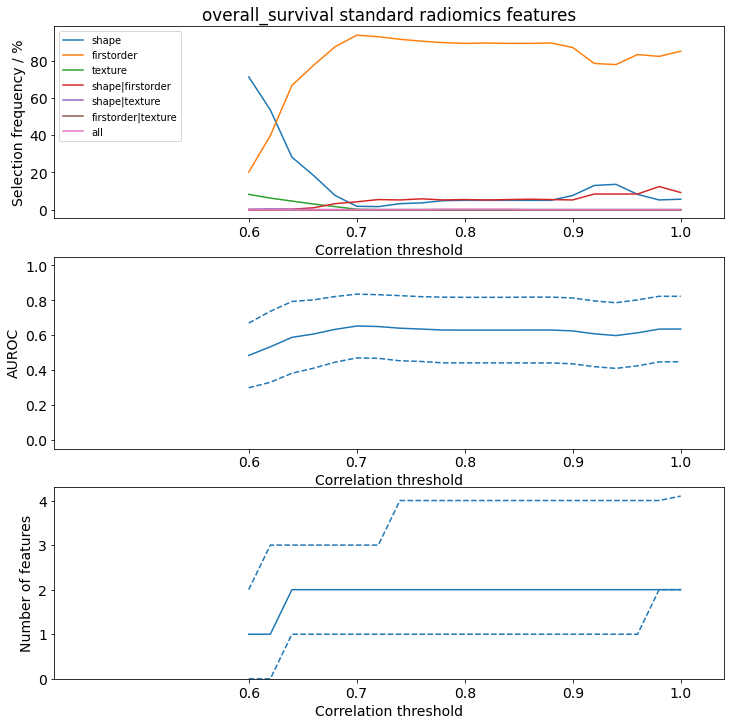

Threshold = 0.7
AUROC (CV) = 0.6526

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,74.400,-0.773
lesion_original_firstorder_InterquartileRange,33.800,0.038


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.703
train CV     = 0.653
test #       = 87 = 5 : 82 (5.7%)
test         = 0.568
test p-value = not computed


____________________
Experiment number 1
Target      overall_survival
Features    Standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


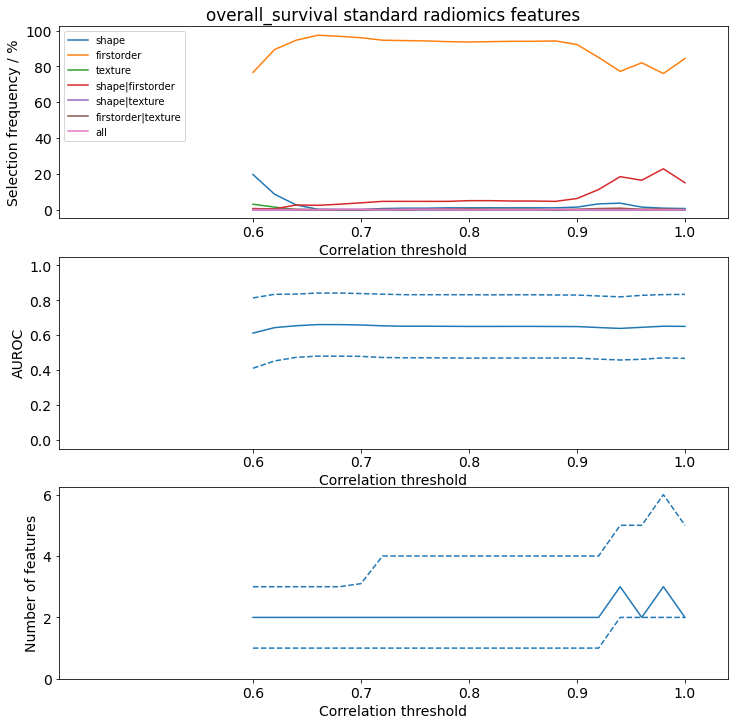

Threshold = 0.66
AUROC (CV) = 0.66086

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,92.200,-0.797
lesion_original_firstorder_Skewness,43.800,0.021
lesion_original_firstorder_InterquartileRange,37.400,0.022


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.714
train CV     = 0.661
test #       = 89 = 5 : 84 (5.6%)
test         = 0.555
test p-value = not computed


____________________
Experiment number 2
Target      overall_survival
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


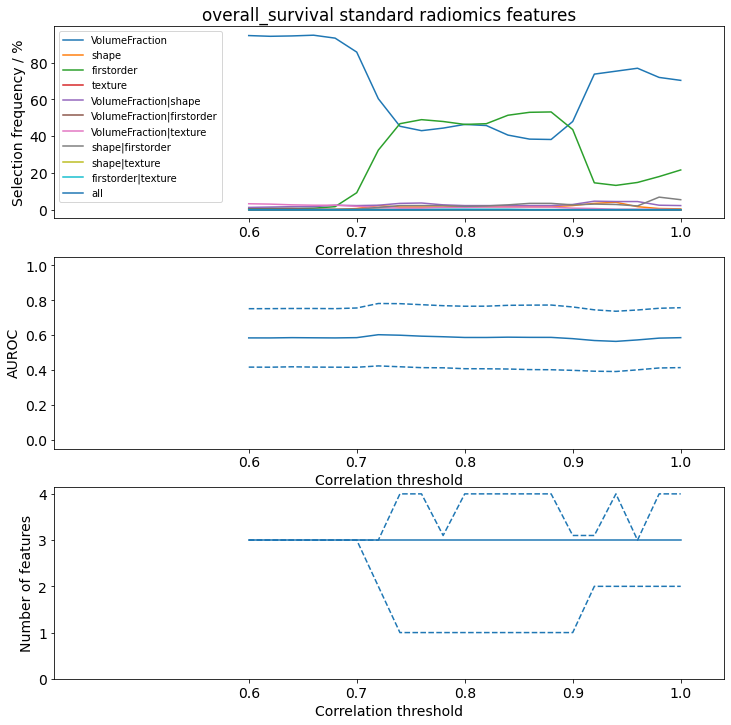

Threshold = 0.72
AUROC (CV) = 0.60282

Feature group = firstorder



Feature,Frequency,Coef
lesion_original_firstorder_90Percentile,33.200,-0.773
lesion_original_firstorder_InterquartileRange,10.600,0.038


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.703
train CV     = 0.603
test #       = 87 = 5 : 82 (5.7%)
test         = 0.568
test p-value = not computed


____________________
Experiment number 3
Target      overall_survival
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


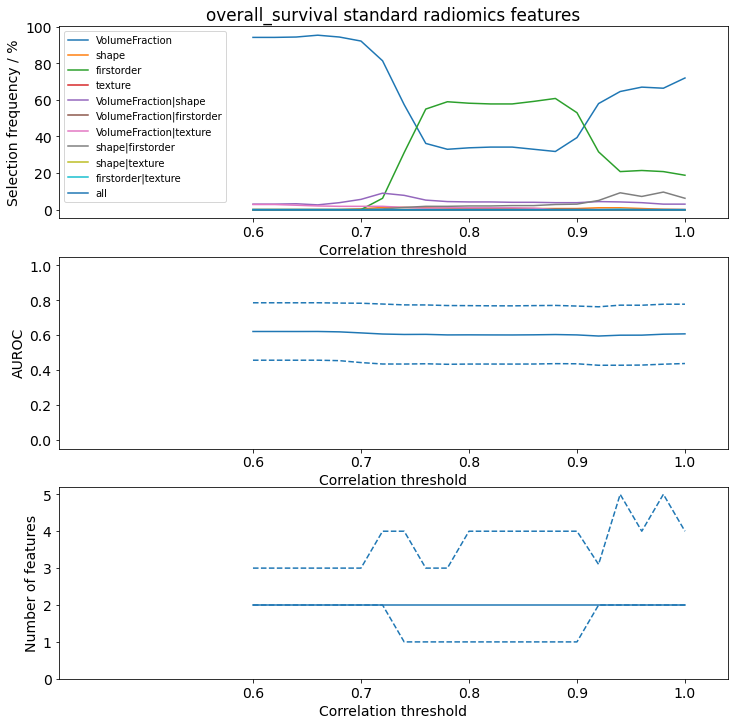

Threshold = 0.66
AUROC (CV) = 0.62133

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_low enhancingVolumeFraction,100.000,0.668
lesion_sarcomaFeature_mid enhancingVolumeFraction,98.600,0.118


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.662
train CV     = 0.621
test #       = 89 = 5 : 84 (5.6%)
test         = 0.626
test p-value = 0.34195268439942106


____________________
Experiment number 4
Target      overall_survival
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


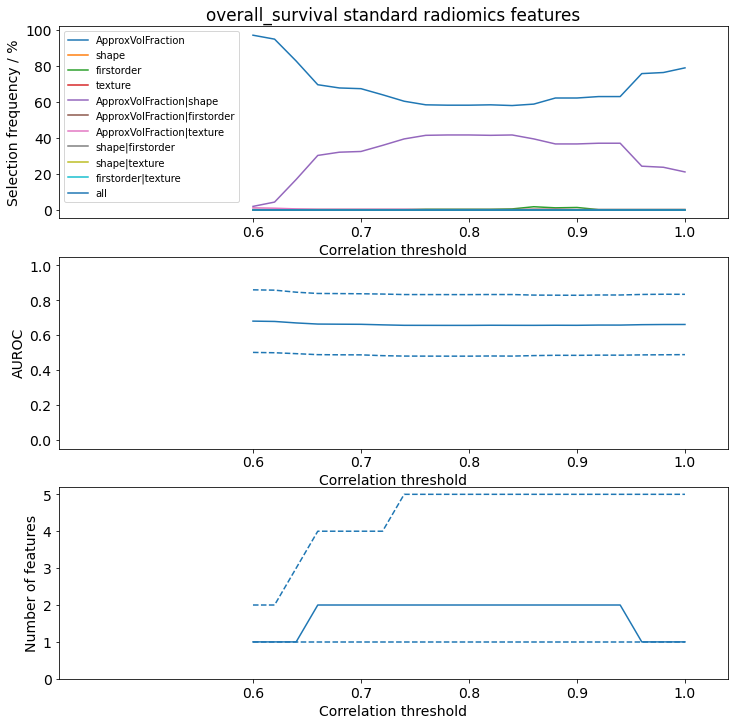

Threshold = 0.6
AUROC (CV) = 0.6807

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,91.800,-0.768


train #      = 145 = 21 : 124 (14.5%)
train resub  = 0.712
train CV     = 0.681
test #       = 87 = 5 : 82 (5.7%)
test         = 0.656
test p-value = 0.24683952723361147


____________________
Experiment number 5
Target      overall_survival
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


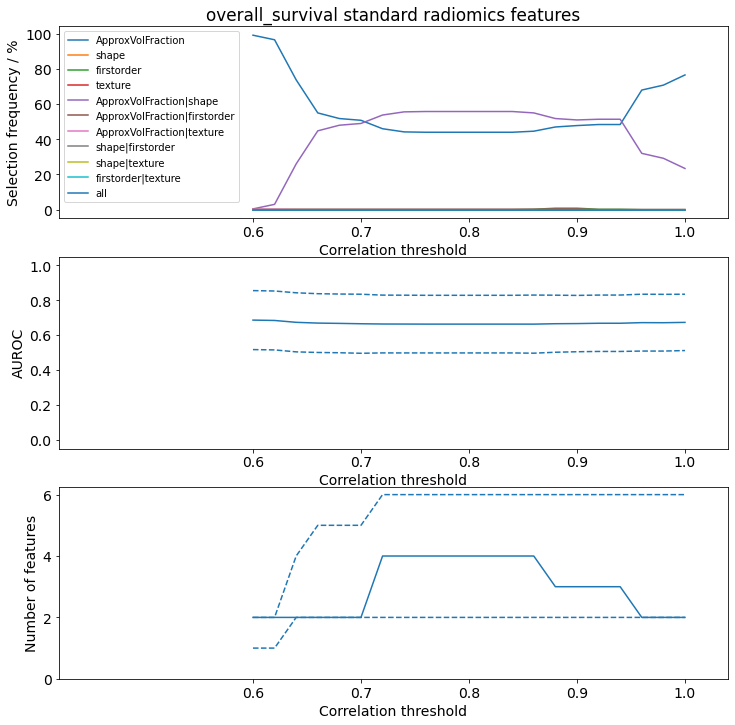

Threshold = 0.6
AUROC (CV) = 0.68656

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,94.400,-0.956
lesion_sarcomaFeature_calcApproxVolFraction,88.800,0.024


train #      = 167 = 21 : 146 (12.6%)
train resub  = 0.72
train CV     = 0.687
test #       = 89 = 5 : 84 (5.6%)
test         = 0.652
test p-value = 0.2578842792219328


____________________
Experiment number 6
Target      distant_recurrence
Features    Standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


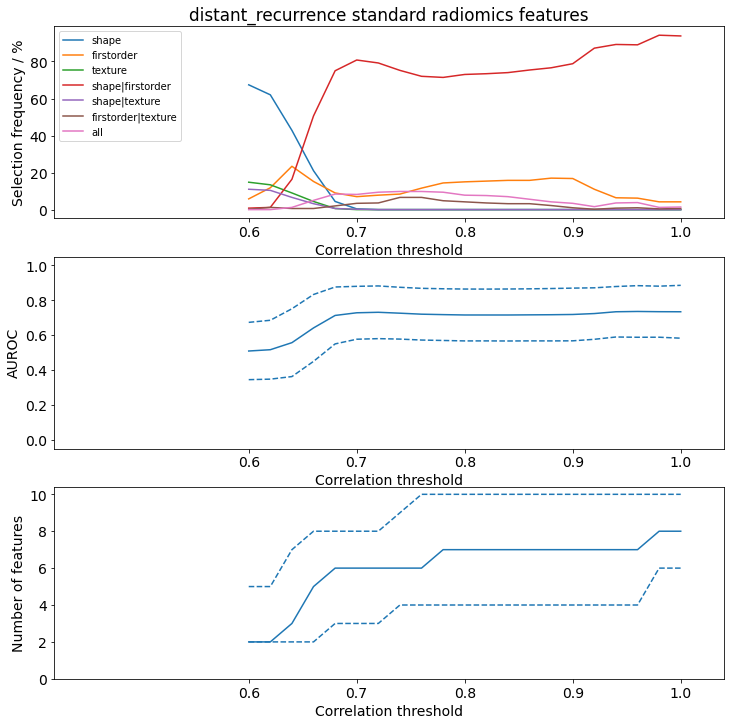

Threshold = 0.96
AUROC (CV) = 0.73609

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_firstorder_Median,99.600,-1.145
lesion_original_shape_Sphericity,92.800,0.733
lesion_original_shape_Flatness,90.400,-0.264
lesion_original_firstorder_90Percentile,82.600,-0.174
lesion_original_shape_Elongation,52.600,-0.022
lesion_original_shape_LeastAxisLength,46.800,-0.056
lesion_original_firstorder_Skewness,43.200,0.008


train #      = 139 = 29 : 110 (20.9%)
train resub  = 0.819
train CV     = 0.736
test #       = 87 = 12 : 75 (13.8%)
test         = 0.552
test p-value = not computed


____________________
Experiment number 7
Target      distant_recurrence
Features    Standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


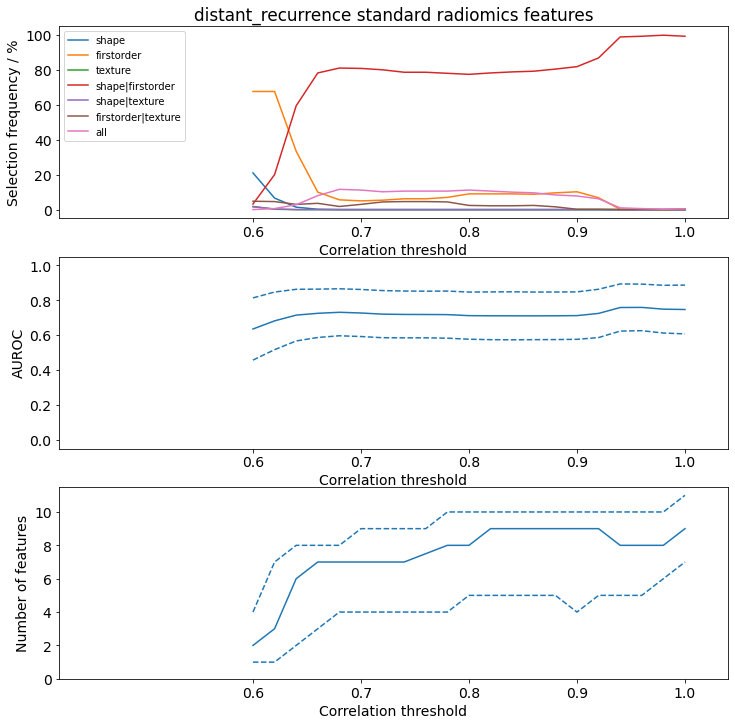

Threshold = 0.96
AUROC (CV) = 0.75939

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,99.800,1.196
lesion_original_shape_Elongation,89.800,-0.188
lesion_original_shape_Flatness,89.800,-0.264
lesion_original_firstorder_Mean,77.400,-1.947
lesion_original_firstorder_Range,68.400,-0.377
lesion_original_firstorder_Kurtosis_log,64.400,0.142
lesion_original_firstorder_Maximum,46.000,0.305
lesion_original_firstorder_RootMeanSquared,38.600,0.081
lesion_original_shape_LeastAxisLength,31.400,-0.012
lesion_original_firstorder_InterquartileRange,24.000,0.061


train #      = 167 = 29 : 138 (17.4%)
train resub  = 0.841
train CV     = 0.759
test #       = 89 = 12 : 77 (13.5%)
test         = 0.582
test p-value = not computed


____________________
Experiment number 8
Target      distant_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


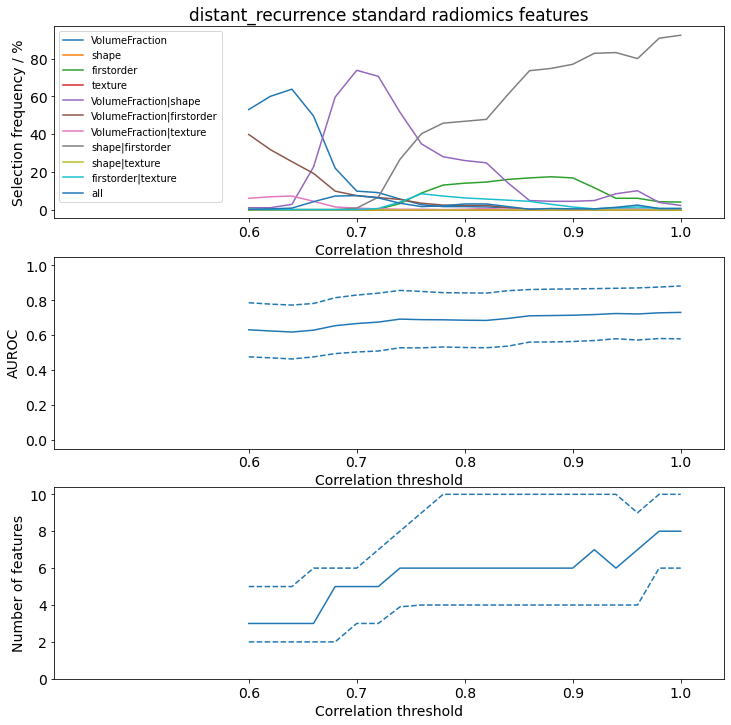

Threshold = 1.0
AUROC (CV) = 0.73079

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,95.200,0.772
lesion_original_shape_Flatness,94.000,-0.276
lesion_original_firstorder_Mean,89.000,-1.167
lesion_original_firstorder_10Percentile,63.800,-0.119
lesion_original_shape_Maximum2DDiameterSlice,63.200,-0.130
lesion_original_firstorder_Median,63.000,-0.109
lesion_original_firstorder_Range,60.400,-0.023
lesion_original_firstorder_Kurtosis_log,55.400,0.051
lesion_original_firstorder_Skewness,53.800,0.013
lesion_original_shape_Elongation,51.200,-0.017


train #      = 139 = 29 : 110 (20.9%)
train resub  = 0.826
train CV     = 0.731
test #       = 87 = 12 : 75 (13.8%)
test         = 0.548
test p-value = not computed


____________________
Experiment number 9
Target      distant_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


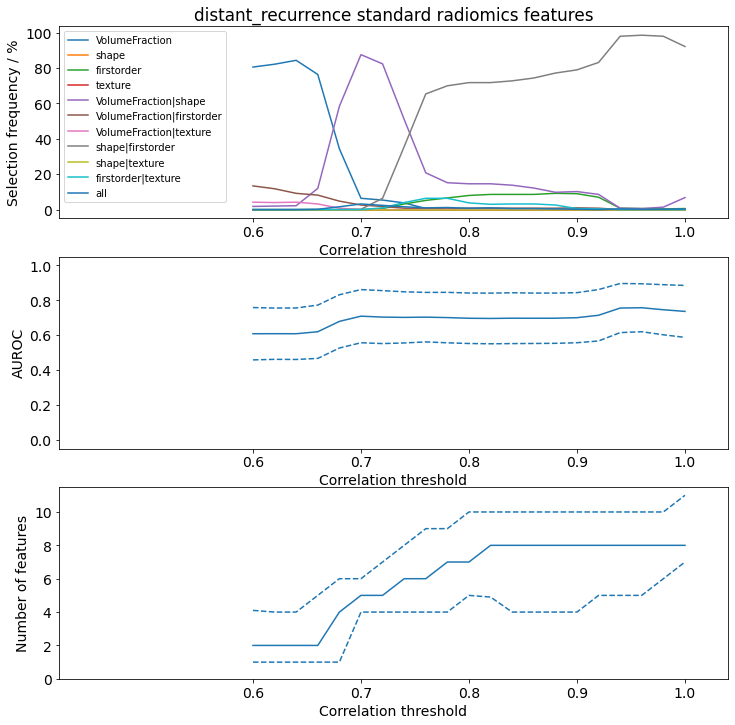

Threshold = 0.96
AUROC (CV) = 0.75743

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,99.400,1.196
lesion_original_shape_Elongation,90.000,-0.188
lesion_original_shape_Flatness,89.800,-0.264
lesion_original_firstorder_Mean,77.800,-1.947
lesion_original_firstorder_Range,67.400,-0.377
lesion_original_firstorder_Kurtosis_log,63.000,0.142
lesion_original_firstorder_Maximum,44.600,0.305
lesion_original_firstorder_RootMeanSquared,38.800,0.081
lesion_original_shape_LeastAxisLength,32.000,-0.012
lesion_original_firstorder_InterquartileRange,23.800,0.061


train #      = 167 = 29 : 138 (17.4%)
train resub  = 0.841
train CV     = 0.757
test #       = 89 = 12 : 77 (13.5%)
test         = 0.582
test p-value = not computed


____________________
Experiment number 10
Target      distant_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


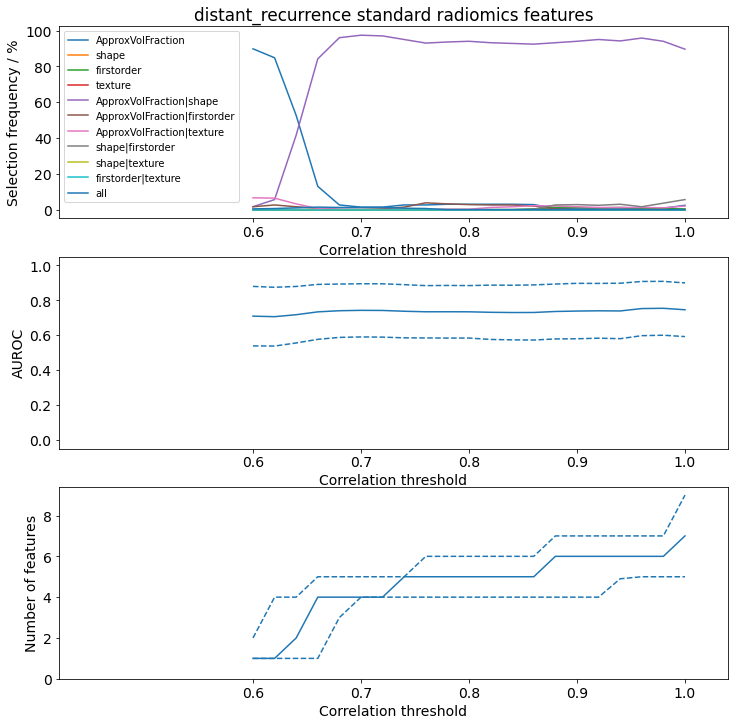

Threshold = 0.98
AUROC (CV) = 0.75424

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,97.600,1.136
lesion_original_shape_Flatness,97.600,-0.414
lesion_sarcomaFeature_highApproxVolFraction,95.800,-1.199
lesion_sarcomaFeature_lowApproxVolFraction,94.000,0.746
lesion_original_shape_Maximum2DDiameterSlice,80.200,-0.272
lesion_original_shape_Elongation,65.400,-0.072
lesion_sarcomaFeature_calcApproxVolFraction,30.600,0.003


train #      = 139 = 29 : 110 (20.9%)
train resub  = 0.828
train CV     = 0.754
test #       = 87 = 12 : 75 (13.8%)
test         = 0.566
test p-value = not computed


____________________
Experiment number 11
Target      distant_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


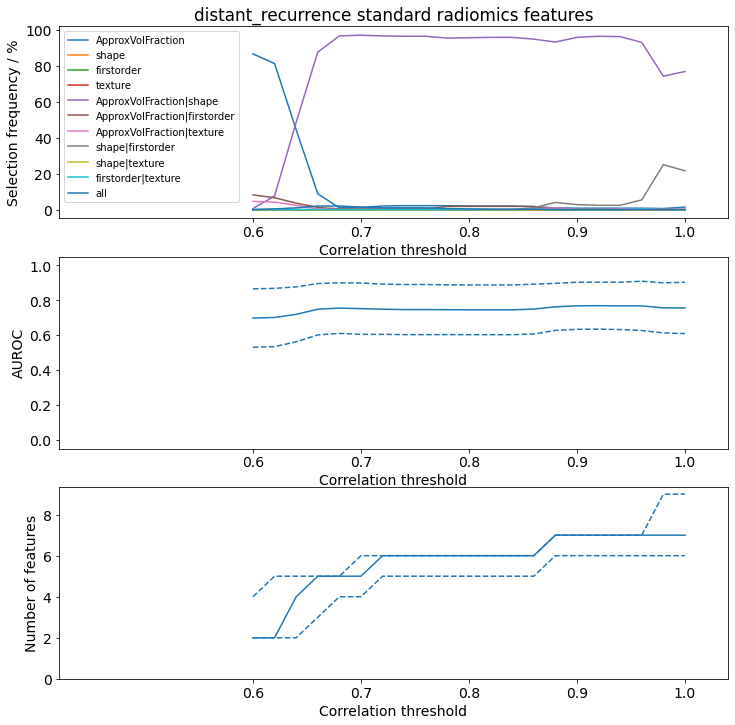

Threshold = 0.92
AUROC (CV) = 0.76927

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,98.800,1.219
lesion_sarcomaFeature_highApproxVolFraction,97.400,-1.080
lesion_sarcomaFeature_lowApproxVolFraction,96.800,0.857
lesion_original_shape_Elongation,96.000,-0.243
lesion_original_shape_Flatness,95.600,-0.246
lesion_sarcomaFeature_calcApproxVolFraction,89.400,0.075
lesion_original_shape_SurfaceVolumeRatio_log,63.200,0.040


train #      = 167 = 29 : 138 (17.4%)
train resub  = 0.824
train CV     = 0.769
test #       = 89 = 12 : 77 (13.5%)
test         = 0.574
test p-value = not computed


____________________
Experiment number 12
Target      local_recurrence
Features    Standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


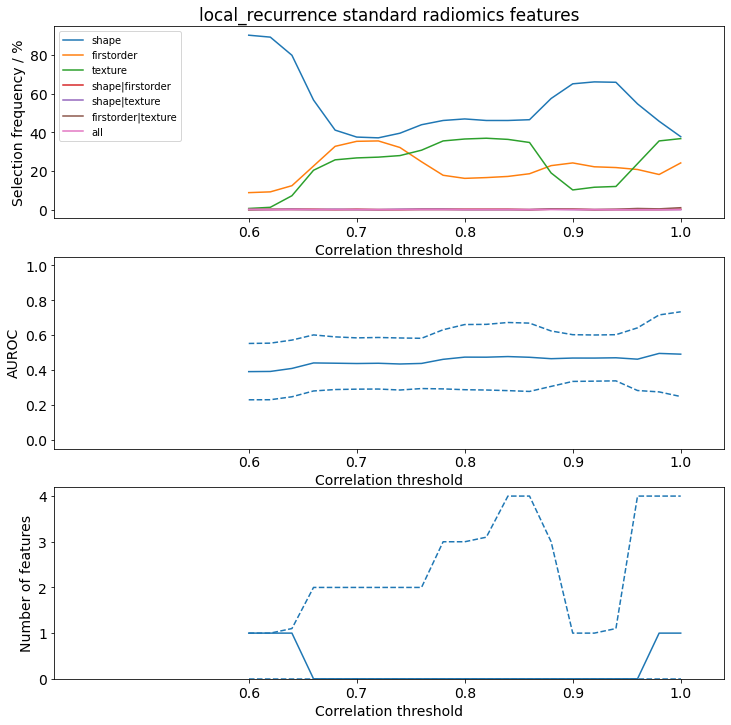

Threshold = 0.98
AUROC (CV) = 0.49556

Feature group = shape



Feature,Frequency,Coef


train #      = 129 = 15 : 114 (11.6%)
train resub  = 0.5
train CV     = 0.496
test #       = 87 = 12 : 75 (13.8%)
test         = 0.5
test p-value = not computed


____________________
Experiment number 13
Target      local_recurrence
Features    Standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


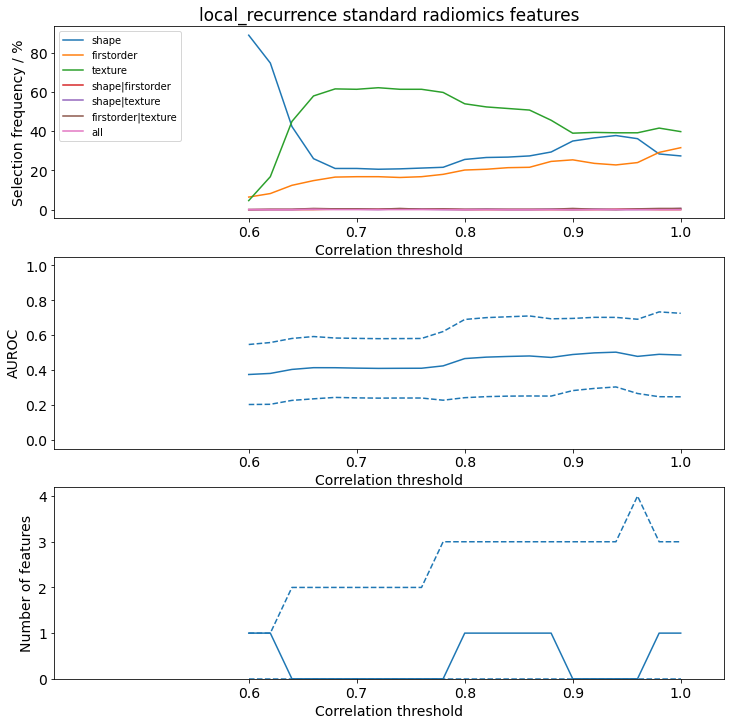

Threshold = 0.94
AUROC (CV) = 0.50273

Feature group = shape



Feature,Frequency,Coef


train #      = 167 = 15 : 152 (9.0%)
train resub  = 0.5
train CV     = 0.503
test #       = 89 = 12 : 77 (13.5%)
test         = 0.5
test p-value = not computed


____________________
Experiment number 14
Target      local_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


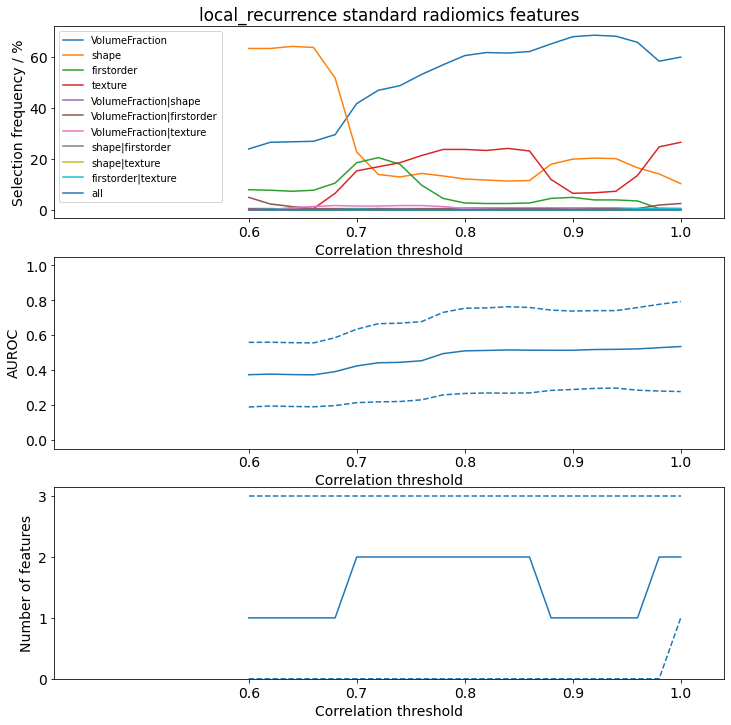

Threshold = 1.0
AUROC (CV) = 0.53489

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,62.000,-0.289


train #      = 129 = 15 : 114 (11.6%)
train resub  = 0.611
train CV     = 0.535
test #       = 87 = 12 : 75 (13.8%)
test         = 0.526
test p-value = not computed


____________________
Experiment number 15
Target      local_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


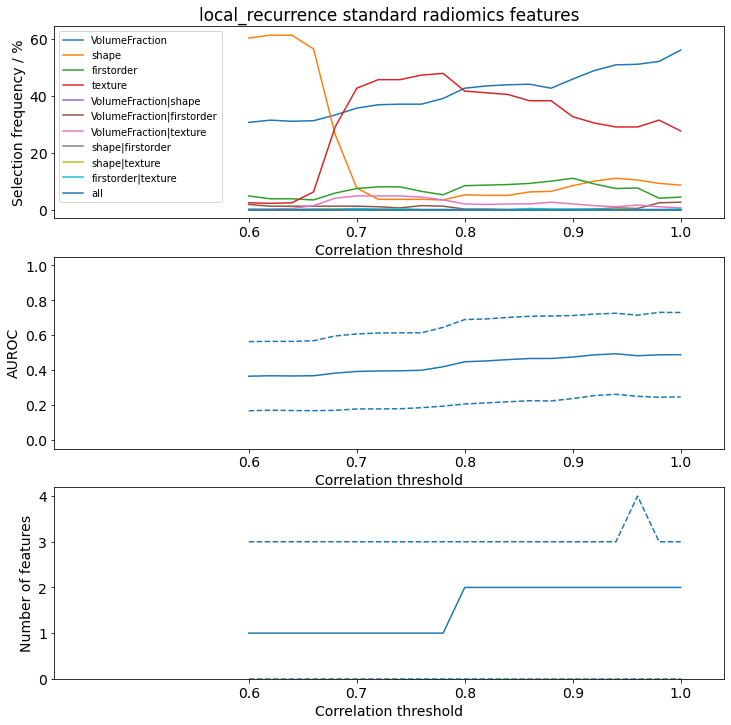

Threshold = 0.94
AUROC (CV) = 0.49347

Feature group = VolumeFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_high enhancingVolumeFraction,48.400,-0.319
lesion_sarcomaFeature_calcificationVolumeFraction,34.600,0.074
lesion_sarcomaFeature_mid enhancingVolumeFraction,27.000,0.066


train #      = 167 = 15 : 152 (9.0%)
train resub  = 0.612
train CV     = 0.493
test #       = 89 = 12 : 77 (13.5%)
test         = 0.528
test p-value = not computed


____________________
Experiment number 16
Target      local_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


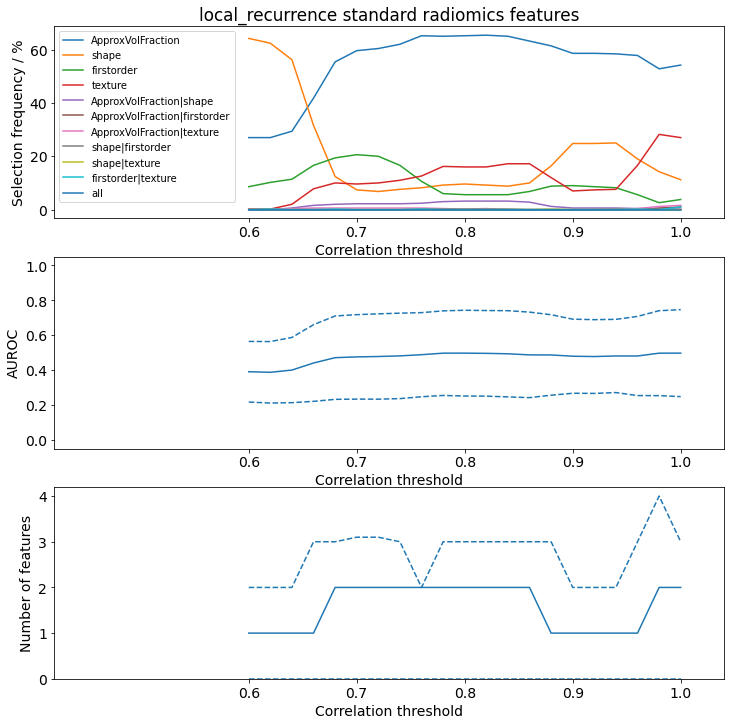

Threshold = 0.8
AUROC (CV) = 0.49715

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,65.400,-0.339
lesion_sarcomaFeature_calcApproxVolFraction,53.000,0.397


train #      = 129 = 15 : 114 (11.6%)
train resub  = 0.578
train CV     = 0.497
test #       = 87 = 12 : 75 (13.8%)
test         = 0.576
test p-value = not computed


____________________
Experiment number 17
Target      local_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


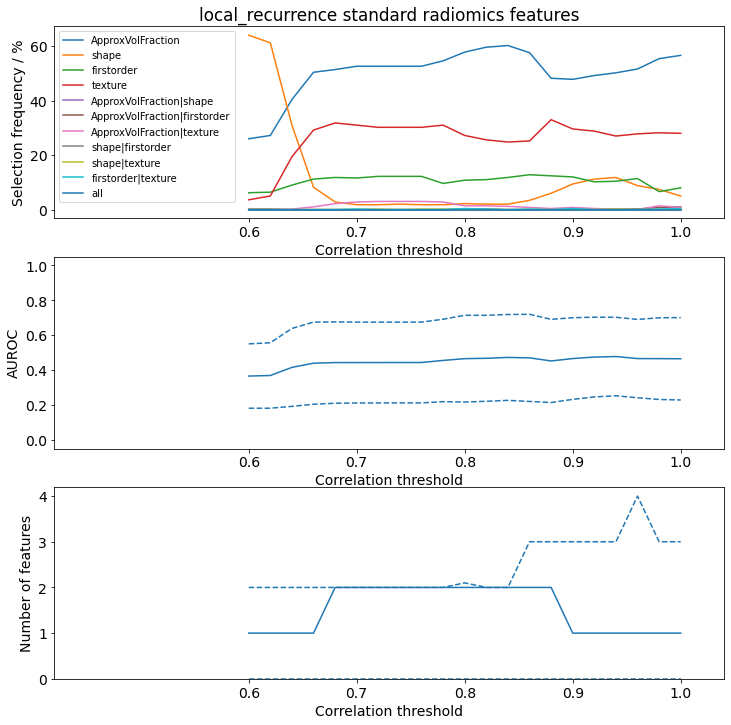

Threshold = 0.94
AUROC (CV) = 0.47778

Feature group = ApproxVolFraction



Feature,Frequency,Coef
lesion_sarcomaFeature_highApproxVolFraction,33.200,-0.215
lesion_sarcomaFeature_calcApproxVolFraction,21.400,0.109


train #      = 167 = 15 : 152 (9.0%)
train resub  = 0.554
train CV     = 0.478
test #       = 89 = 12 : 77 (13.5%)
test         = 0.554
test p-value = not computed


____________________
Experiment number 18
Target      any_recurrence
Features    Standard radiomics features
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


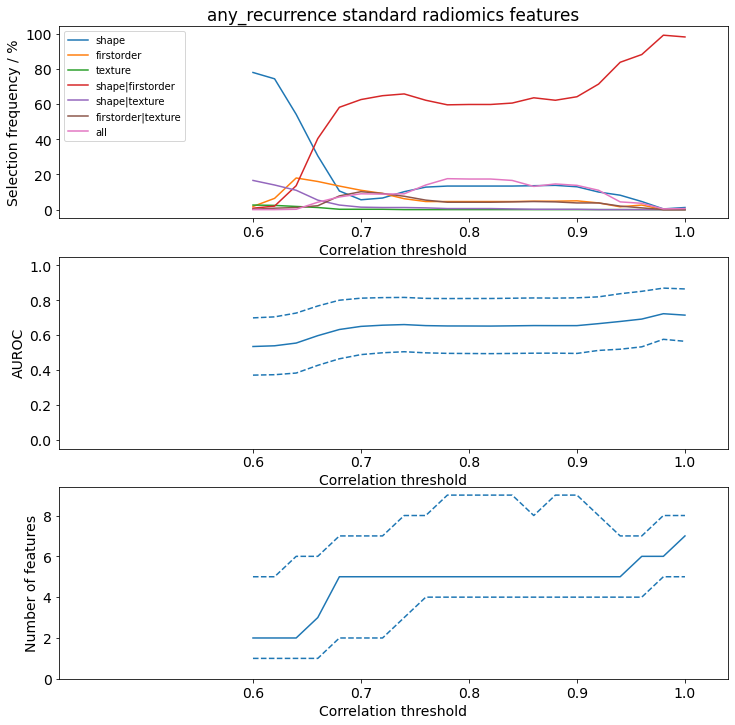

Threshold = 0.98
AUROC (CV) = 0.72318

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.967
lesion_original_firstorder_10Percentile,99.600,-0.955
lesion_original_shape_Flatness,96.000,-0.358
lesion_original_firstorder_Skewness,90.400,0.145
lesion_original_firstorder_Median,76.600,-0.150


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.79
train CV     = 0.723
test #       = 79 = 10 : 69 (12.7%)
test         = 0.655
test p-value = 0.11635537238360177


____________________
Experiment number 19
Target      any_recurrence
Features    Standard radiomics features
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


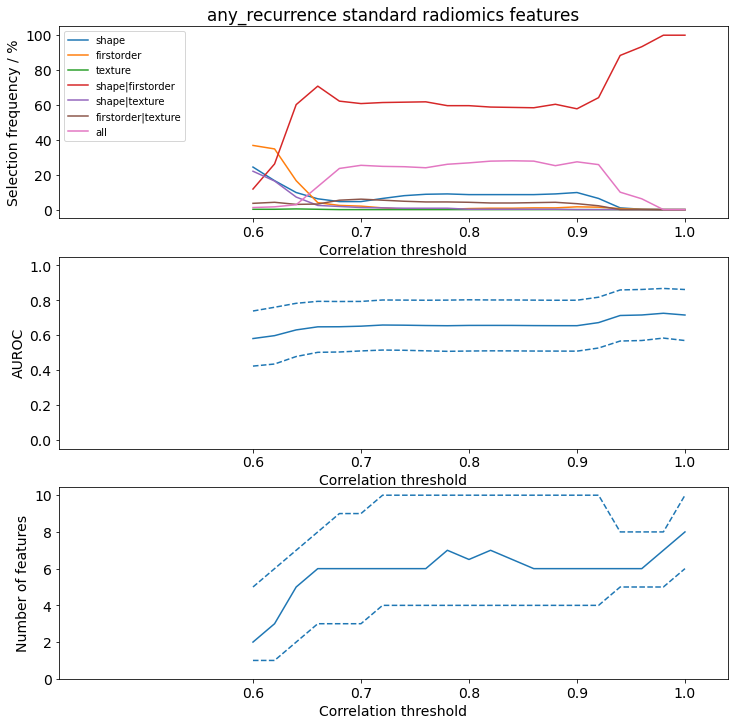

Threshold = 0.98
AUROC (CV) = 0.72576

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.989
lesion_original_firstorder_10Percentile,99.000,-0.935
lesion_original_shape_Flatness,96.600,-0.320
lesion_original_firstorder_Skewness,83.000,0.090
lesion_original_firstorder_Maximum,68.800,0.061
lesion_original_firstorder_Mean,61.600,-0.235


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.786
train CV     = 0.726
test #       = 89 = 10 : 79 (11.2%)
test         = 0.68
test p-value = 0.06602078240787206


____________________
Experiment number 20
Target      any_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


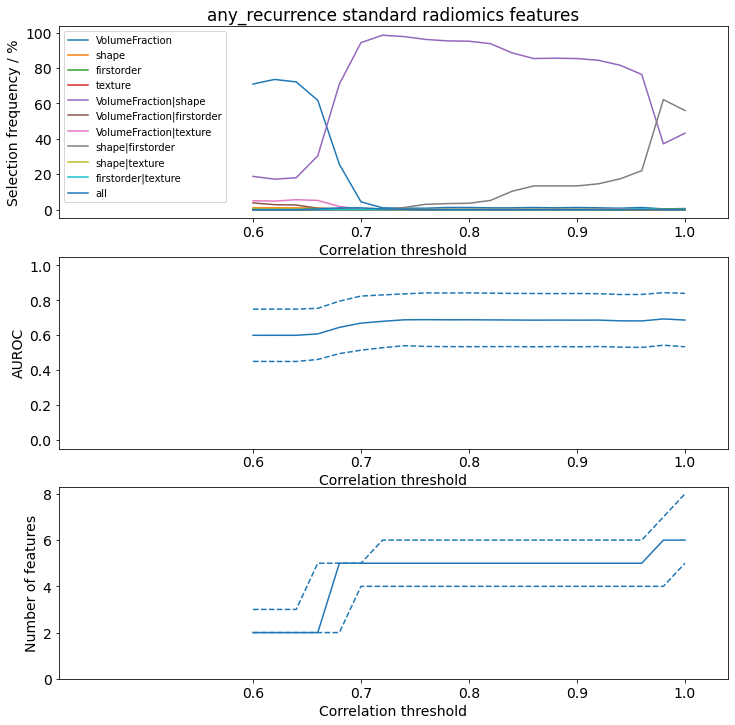

Threshold = 0.98
AUROC (CV) = 0.69324

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,99.400,0.967
lesion_original_shape_Flatness,97.400,-0.358
lesion_original_firstorder_10Percentile,62.200,-0.955
lesion_original_firstorder_Skewness,57.000,0.145
lesion_original_firstorder_Median,45.400,-0.151


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.79
train CV     = 0.693
test #       = 79 = 10 : 69 (12.7%)
test         = 0.655
test p-value = 0.11635537238360177


____________________
Experiment number 21
Target      any_recurrence
Features    Standard radiomics features + volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


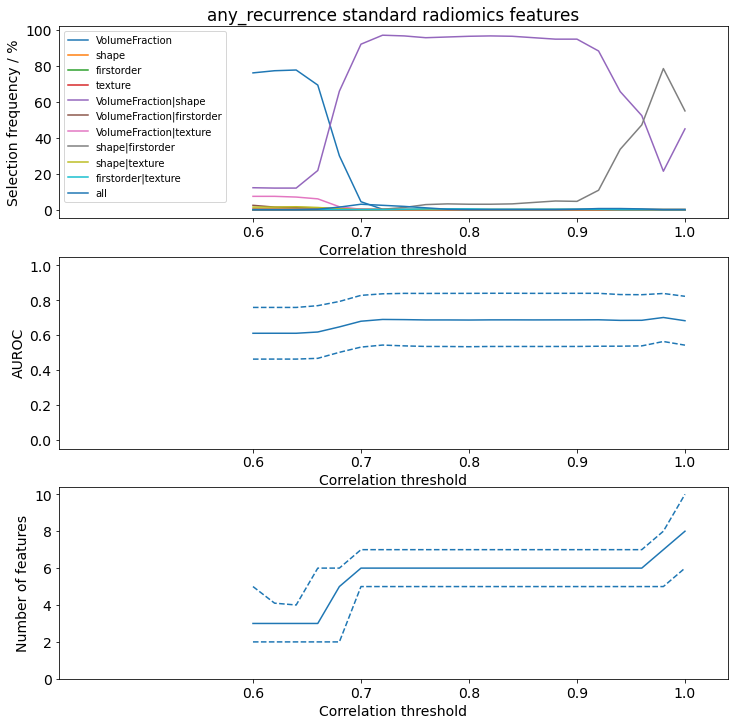

Threshold = 0.98
AUROC (CV) = 0.70151

Feature group = shape|firstorder



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.989
lesion_original_shape_Flatness,98.600,-0.320
lesion_original_firstorder_10Percentile,78.000,-0.935
lesion_original_firstorder_Skewness,68.200,0.090
lesion_original_firstorder_Maximum,52.400,0.061
lesion_original_firstorder_Mean,46.200,-0.235


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.786
train CV     = 0.702
test #       = 89 = 10 : 79 (11.2%)
test         = 0.68
test p-value = 0.06602078240787206


____________________
Experiment number 22
Target      any_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   True
Replace TU  None
Remove RX   True
_____________________
.....................


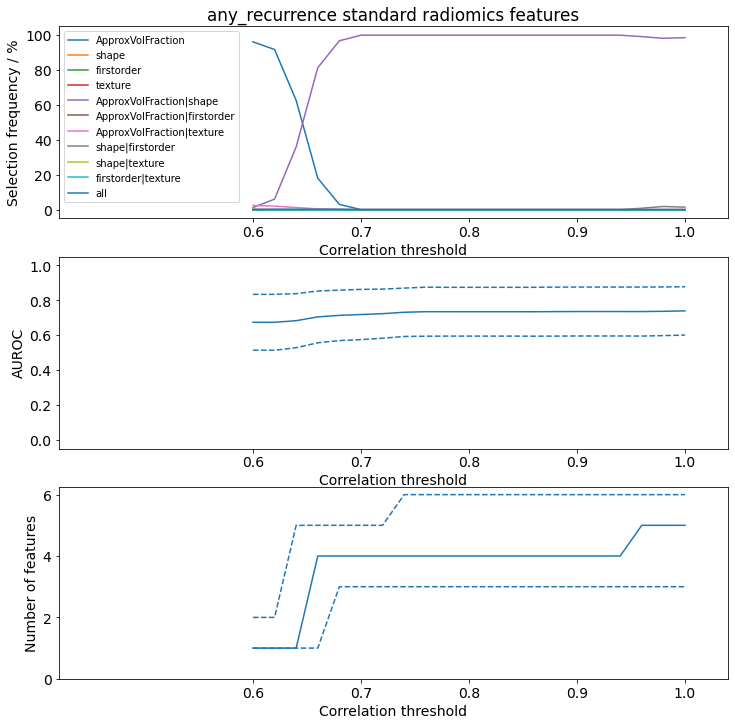

Threshold = 1.0
AUROC (CV) = 0.73934

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.871
lesion_original_shape_Flatness,99.800,-0.326
lesion_sarcomaFeature_highApproxVolFraction,98.600,-1.079
lesion_sarcomaFeature_lowApproxVolFraction,58.200,0.072
lesion_sarcomaFeature_calcApproxVolFraction,42.200,0.005
lesion_original_shape_Maximum2DDiameterSlice,33.200,-0.024


train #      = 142 = 40 : 102 (28.2%)
train resub  = 0.784
train CV     = 0.739
test #       = 79 = 10 : 69 (12.7%)
test         = 0.696
test p-value = 0.047356896036890875


____________________
Experiment number 23
Target      any_recurrence
Features    Standard radiomics features + approximate volume fraction
Remove TU   False
Replace TU  No event
Remove RX   True
_____________________
.....................


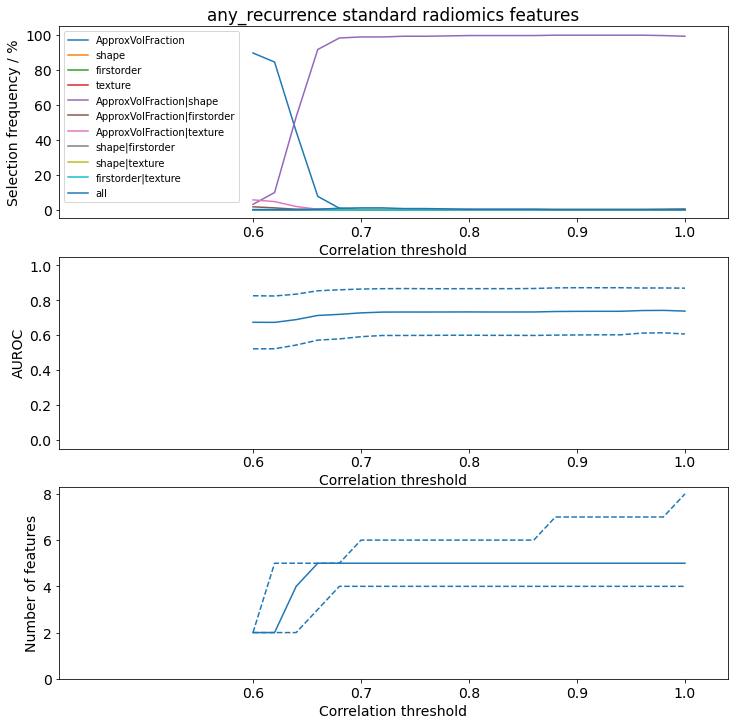

Threshold = 0.98
AUROC (CV) = 0.7423

Feature group = ApproxVolFraction|shape



Feature,Frequency,Coef
lesion_original_shape_Sphericity,100.000,0.865
lesion_original_shape_Flatness,99.800,-0.285
lesion_sarcomaFeature_highApproxVolFraction,99.800,-1.124
lesion_sarcomaFeature_calcApproxVolFraction,92.400,0.076
lesion_sarcomaFeature_lowApproxVolFraction,57.400,0.036
lesion_original_shape_Maximum2DDiameterSlice,41.400,-0.000


train #      = 167 = 40 : 127 (24.0%)
train resub  = 0.78
train CV     = 0.742
test #       = 89 = 10 : 79 (11.2%)
test         = 0.699
test p-value = 0.04203701913482783


____________________
Failed experiments = 
[]


In [12]:
dfResults = None

failedExpID = []

for nExp, experiment in enumerate(experiments):

    # experiment settings
    target = experiment['target']
    featureSet = experiment['featureSet']
    rmTU = experiment['removeTargetUnknown']
    rpTU = experiment['replaceTargetUnknown']
    rmRX = experiment['removeRxPatients']
    
    print('Experiment number ' + str(nExp))
    zf = 12
    print('Target'.ljust(zf) + target)
    print('Features'.ljust(zf) + settingsDict[featureSet]['name'])
    print('Remove TU'.ljust(zf) + str(rmTU))
    print('Replace TU'.ljust(zf) + str(rpTU))
    print('Remove RX'.ljust(zf) + str(rmRX))

    try:
                
        df = prepData(dfClinical, dfRad, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)
        dfTest = prepData(dfClinicalTest, dfRadTest, target, featureSet, removeTargetUnknown=rmTU, replaceTargetUnknown=rpTU, removeRxPatients=rmRX)

        fileName = '_'.join(['result', 
                             target,  
                             settingsDict[featureSet]['ID'],
                             str(rmTU),
                             str(rpTU),
                             str(rmRX)])
        quickLoadFile = os.path.join(outputFolder, fileName + '.pickle')

        modelFit = fitModelOrLoadSaved(df, target, settingsDict[featureSet], quickLoadFile)

        if displayAll:
            plotResultExperiments(modelFit, 
                                  titleStr=fileName.replace('result','').replace('_',' '),
                                  outputFile=os.path.join(outputFolder, 'figures', fileName + '.pdf'))

        bestCoef, pdFreq, bestThreshold, bestFeatureGroup = displayOneExperiment(modelFit)
        pdFreq = pdFreq.loc[pdFreq.Coef!='',:] # trim off any coeff that aren't in the best model
        display(pdFreq.style.hide_index())

        result = getTrainTestResults(modelFit)

        resultDict = experiment.copy()
        resultDict = dict(resultDict, **result)
        resultDict['threshold'] = bestThreshold
        resultDict['feature group'] = bestFeatureGroup
        resultDict['file name'] = fileName

        if dfResults is None:
            dfResults = pd.DataFrame([resultDict])
        else:
             dfResults = dfResults.append(resultDict, ignore_index=True)   

        dfResults.to_excel(os.path.join(outputFolder, 'results.xlsx'), index=False)
        
    except:
        print('FAILED')
        failedExpID.append(nExp)
        
    
    print('_'*20)

print('Failed experiments = ')
print(failedExpID)

## Re-save the copy of this notebook once it is completed

In [16]:
from IPython.display import display, Javascript
import time

# save current state of notebook and wait a bit as the actual save happens with a short delay
display(Javascript('IPython.notebook.save_checkpoint();'))
time.sleep(10)

# copy notebook to output folder
if saveOutputs:
    jupyterFile = os.path.join(os.path.abspath(""), 'LR_GroupSelection_withValidation_andOutcome.ipynb')
    shutil.copyfile(jupyterFile, os.path.join(outputFolder, 'code', 'LR_GroupSelection_withValidation_andOutcome.ipynb'))

<IPython.core.display.Javascript object>